# RETO: Detección de Transacciones Fraudulentas

#### Integrantes:
- Jessica Bilbao Restrepo
- Santago Gómez Montoya

#### Descripción del reto:
Para este trabajo, ustedes serán consultores de una Empresa Analítica la cual intenta ganar un contrato para trabajar distintos modelos analíticos de una Entidad Financiera Multinacional. Para seleccionar la consultora, se ha impuesto un reto a varias empresas candidatas con información real anónima.
Adjunto encontrarán una base de datos con transacciones monetarias de diversos tipos. A continuación, está una descripción de los campos:

#### Descripción de los campos:

- Step: Unidad de tiempo (horas)
- Type: Tipo de transacción: CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER
- Amount: Monto de la transacción en moneda local
- NameOrig: Cliente originador de la transacción
- OldBalanceOrg: Balance inicial del cliente originador (Antes de la transacción)
- NewBalanceOrig: Nuevo balance del cliente originador (Después de la transacción)
- NameDest: Cliente destinatario de la transacción
- OldBalanceDest: Balance inicial del cliente destinatario (Antes de la transacción)
- NewBalanceDest: Nuevo balance del cliente destinatario (Después de la transacción)
- isFraud: Un impostor toma control de las cuentas de los clientes e intenta vaciarlas mediante transacciones a otras cuentas para luego retirar el dinero ("cash-out").
- isFlaggedFraud: Un intento ilegal de transferir grandes cantidades de dinero en una sola transacción.

#### EL OBJETIVO: 
Elaborar un modelo que permita la detección de transacciones fraudulentas.


### Librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay

## Lectura y tratamiento de datos

In [2]:
df = pd.read_csv('data/fraud.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0


### Descripción general de datos númericos

In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,101613.000000,1.016130e+05,1.016130e+05,1.016130e+05,1.016130e+05,1.016130e+05,101613.000000,101613.0
mean,8.523457,1.740901e+05,9.071753e+05,9.234992e+05,8.810428e+05,1.183998e+06,0.001142,0.0
std,1.820681,3.450199e+05,2.829575e+06,2.867319e+06,2.399949e+06,2.797761e+06,0.033768,0.0
min,1.000000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,1.001659e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,9.000000,5.338541e+04,2.019047e+04,0.000000e+00,2.105800e+04,5.178343e+04,0.000000,0.0
75%,10.000000,2.124984e+05,1.947150e+05,2.192178e+05,5.919217e+05,1.063122e+06,0.000000,0.0
max,10.000000,1.000000e+07,3.893942e+07,3.894623e+07,3.400874e+07,3.894623e+07,1.000000,0.0


### Verificación de datos nulos

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Al hacer un análisis más profundo de los datos, identificamos que algunas variables categoricas y númericas no aportaban características de valor para la detección de transacciones fraudulentas.
En este caso:
- step
- nameOrig
- nameDest
- isflaggedFraud (esta en específico presentaba el valor 0 en todas las filas)

Por lo que eliminamos estas columnas del conjunto de datos

In [5]:
df = df.drop(['step','nameOrig','nameDest','isFlaggedFraud'],axis=1)
df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
101608,PAYMENT,7477.02,785.00,0.00,0.00,0.00,0
101609,CASH_OUT,282252.35,220339.29,0.00,95156.01,91286.97,0
101610,PAYMENT,17289.01,0.00,0.00,0.00,0.00,0
101611,TRANSFER,1347146.45,1605.00,0.00,541639.43,2186953.43,0


### Gráficas
Para analizar mejor el comportamiento de las demás características hicimos algunas gráficas para ver como se relacionaba cada una con la variable objetivo (isFraud)

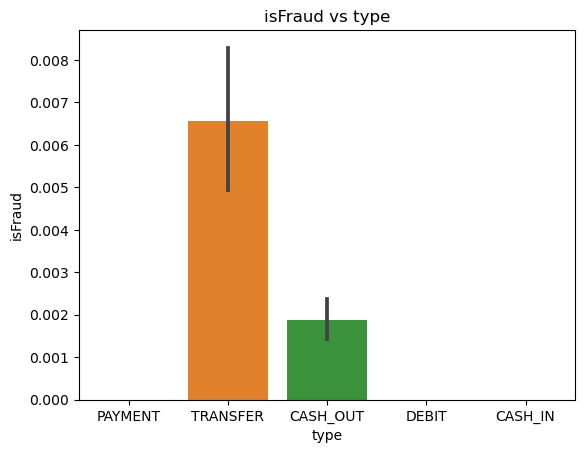

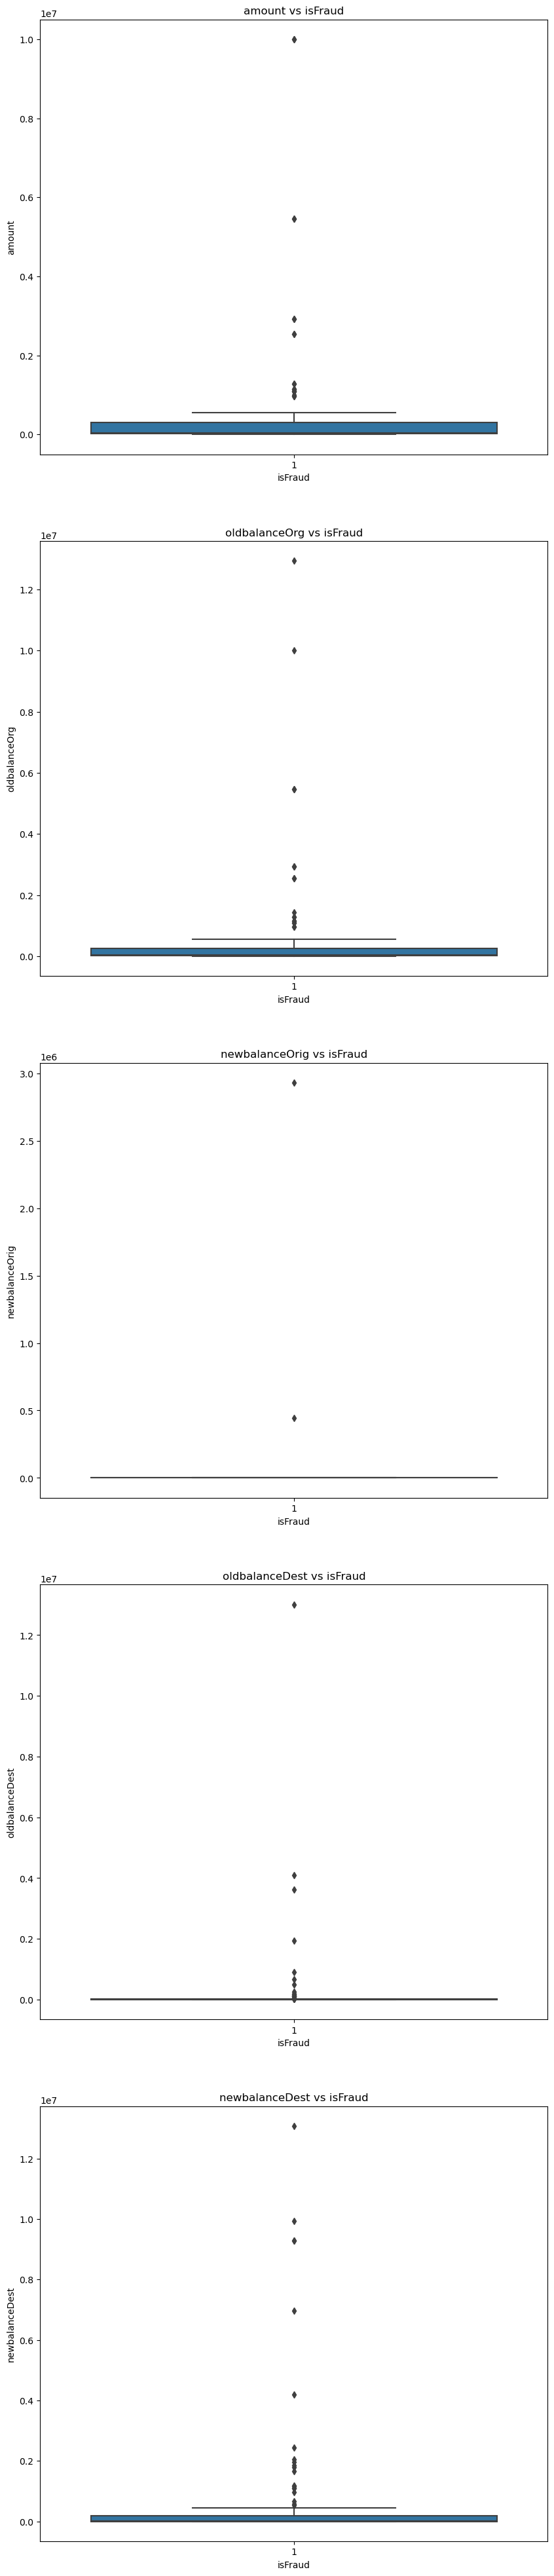

In [6]:
sns.barplot(data = df, x = 'type' , y = 'isFraud').set(title='isFraud vs {0}'.format('type'))

fig = plt.figure(figsize = [10,50])
cols = list(df.columns)
cols.remove('isFraud')
cols.remove('type')
fraud = df.loc[df['isFraud'] == 1]
cnt = 1
for col in cols :
    plt.subplot(5,1,cnt)
    sns.boxplot(data = fraud, x = 'isFraud', y = col).set(title='{0} vs isFraud'.format(col))
    cnt+=1
plt.show()

El comportamiento de los datos en las gráficas logra ser expresivo y coherente al comportamiento natural de un fraude, con esto se quiere decir en forma más específica que, las variables de nuevo y viejo balance tanto de las cuentas de origen como destino explican que cuando se trata de un fraude la cuenta destino tenía un balance bajo y luego tiene un balance alto de forma más recurrente como valores atípicos, pero aún así lo normal es que los datos están todos al rededor de una densidad baja de valores.
Luego con respecto a las cuentas de origen al comienzo tienen una densidad de valores mayores a cero (es decir, tienen dinero en sus cuentas) y luego su nuevo balance es casi cero o cero, todo esto obviamente cuando se trata de un fraude.

### Creación de variables dummies
Se crear variables dummies de las caracteristicas categoricas, especificamente el campo "type" para que sea más fácil para el modelo predecir un fraude

In [7]:
df = pd.get_dummies(df)
df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0
2,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,1
3,181.00,181.00,0.00,21182.00,0.00,1,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,7477.02,785.00,0.00,0.00,0.00,0,0,0,0,1,0
101609,282252.35,220339.29,0.00,95156.01,91286.97,0,0,1,0,0,0
101610,17289.01,0.00,0.00,0.00,0.00,0,0,0,0,1,0
101611,1347146.45,1605.00,0.00,541639.43,2186953.43,0,0,0,0,0,1


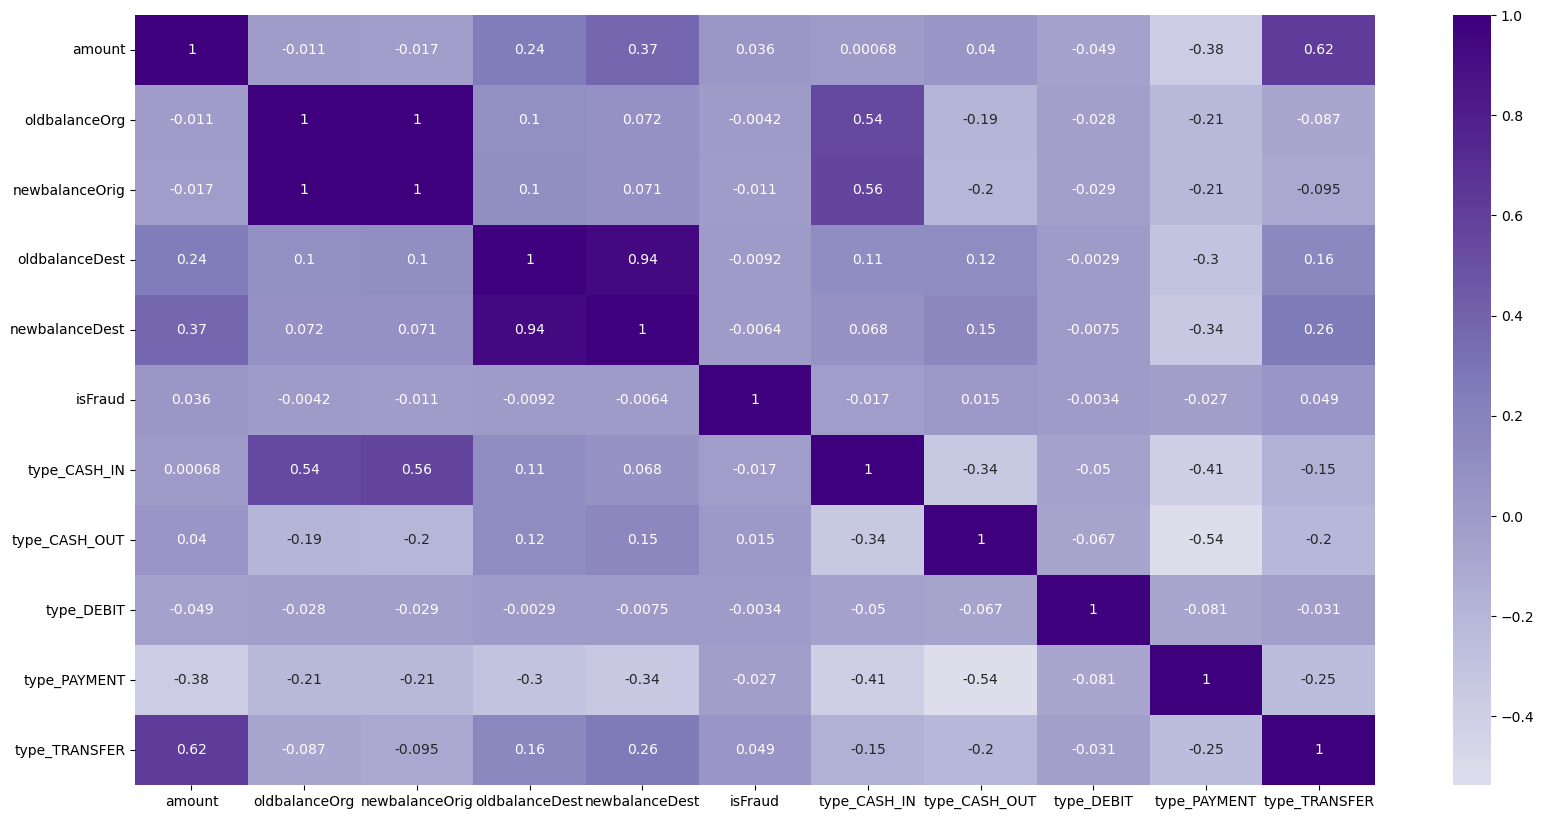

In [8]:
fig = plt.figure(figsize = [20,10])
sns.heatmap(df.corr(), annot = True, cmap = 'Purples', center = 0)
plt.show()

Se hizo además un grafico "heatmap" para identificar la correlación de las variables presentes. Analizando esta gráfica nos damos cuenta que no existe una relación marcada de la variable objetivo "isFraud" con las demás, por lo que no puede encontrarse una variable en específico que nos indique que se trata de un fraude y se hace necesario entonces analizar todo el conjunto de variables para encontrar un comportamiento en común, que se hará a continuación con los modelos de predicción.

### Se hace la división de datos (Características y variable objetivo)

In [9]:
x = df.drop('isFraud', axis=1)
y = df.isFraud

In [10]:
x

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,1,0
2,181.00,181.00,0.00,0.00,0.00,0,0,0,0,1
3,181.00,181.00,0.00,21182.00,0.00,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
101608,7477.02,785.00,0.00,0.00,0.00,0,0,0,1,0
101609,282252.35,220339.29,0.00,95156.01,91286.97,0,1,0,0,0
101610,17289.01,0.00,0.00,0.00,0.00,0,0,0,1,0
101611,1347146.45,1605.00,0.00,541639.43,2186953.43,0,0,0,0,1


In [11]:
y

0         0
1         0
2         1
3         1
4         0
         ..
101608    0
101609    0
101610    0
101611    0
101612    0
Name: isFraud, Length: 101613, dtype: int64

### Se dividen los datos de entrenamiento y valicación

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1234)

### Primero se hizo un análisis general de los modelos clasificadores candidatos para la identificación de fraudes con sus valores por defecto y así encontrar cual o cuales tienen más potencial para la solución del reto

## Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)
tree_score = tree.score(x_test, y_test)
tree_score

0.9989174826551198

## Bagging

In [14]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(DecisionTreeClassifier(),random_state=42)
bagging.fit(x_train, y_train)
bagging_score = bagging.score(x_test, y_test)
bagging_score

0.9990650986566944

## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(x_train, y_train)
random_forest_score = random_forest.score(x_test, y_test)
random_forest_score

0.9993111253259853

## Extremely Randomized Trees

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree = ExtraTreesClassifier(random_state=42)
extra_tree.fit(x_train, y_train)
extra_tree_score = extra_tree.score(x_test, y_test)
extra_tree_score

0.9993111253259853

## AdaBoost Classifier

In [17]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(x_train, y_train)
adaboost_score = adaboost.score(x_test, y_test)
adaboost_score

0.9987206613196871

## LightGBM Classifier

In [18]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(x_train, y_train)
lgbm_score = lgbm.score(x_test, y_test)
lgbm_score

0.9963095999606357

## XGboost Classifier

In [19]:
from xgboost import XGBClassifier
xgboost = XGBClassifier()
xgboost.fit(x_train, y_train)
xgboost_score = xgboost.score(x_test, y_test)
xgboost_score

0.9992619199921271

### Analizamos los resultados finales de cada modelo

In [20]:
list_summary = [['Desicion Tree Classifier', tree_score],
          ['Bagging Classifier', bagging_score],
          ['Random Forest', random_forest_score],
          ['Extremely Randomized Tree', extra_tree_score],
          ['AdaBoost Classifier', adaboost_score],
          ['LGBM Classifier', lgbm_score],
          ['XGBOOST Classifier', xgboost_score]]

summary = pd.DataFrame(list_summary, columns=['Model', 'Score'])
summary

,Model,Score
0,Desicion Tree Classifier,0.998917
1,Bagging Classifier,0.999065
2,Random Forest,0.999311
3,Extremely Randomized Tree,0.999311
4,AdaBoost Classifier,0.998721
5,LGBM Classifier,0.996310
6,XGBOOST Classifier,0.999262


<Axes: title={'center': 'Comparación de Score de Modelos'}, xlabel='Model'>

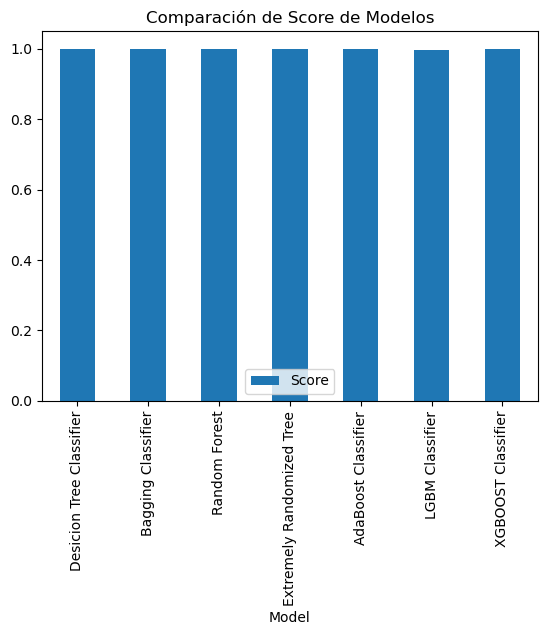

In [21]:
summary.plot(kind='bar', x='Model', y='Score', title = 'Comparación de Score de Modelos')

Aunque todos los modelos demostraron un buen rendimientos para la detección de transacciones fraudulentas, decidimos probar con dos, Random Forest y XGboost, ya que tuvieron de los mejores porcentajes, según lo investigado ambos han sido usados para este de retos y además son buenos para trabajar con datos desbalanceados, muy ideal para este caso ya que hay un gran porcentaje de registros que no son fraude y muy poco de los que sí lo son.

In [24]:
legit = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
legit_percent = (legit/(legit+fraud))*100
fraud_percent = (fraud/(legit+fraud))*100

print("Porcentaje de transacciones sin fraude: {:.4f} %".format(legit_percent))
print("Porcentaje de transacciones con fraude: {:.4f} %".format(fraud_percent))

Porcentaje de transacciones sin fraude: 99.8858 %
Porcentaje de transacciones con fraude: 0.1142 %


## Random Forest Tunning

In [25]:
random_forest = RandomForestClassifier(
    random_state=4, 
    n_estimators=900, 
    max_depth=100, 
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.7
)
random_forest.fit(x_train, y_train)
random_forest_score = random_forest.score(x_test, y_test)
random_forest_score

0.9993111253259853

### Análisis de resultados de Random Forest

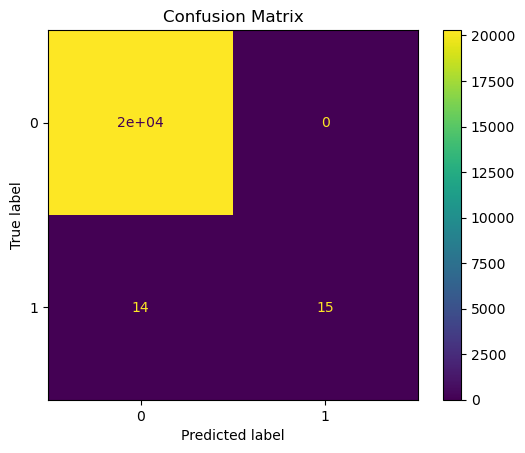

Precisión: 1.0
Recall: 0.5172413793103449
Área bajo la curva ROC: 0.9623024301390253


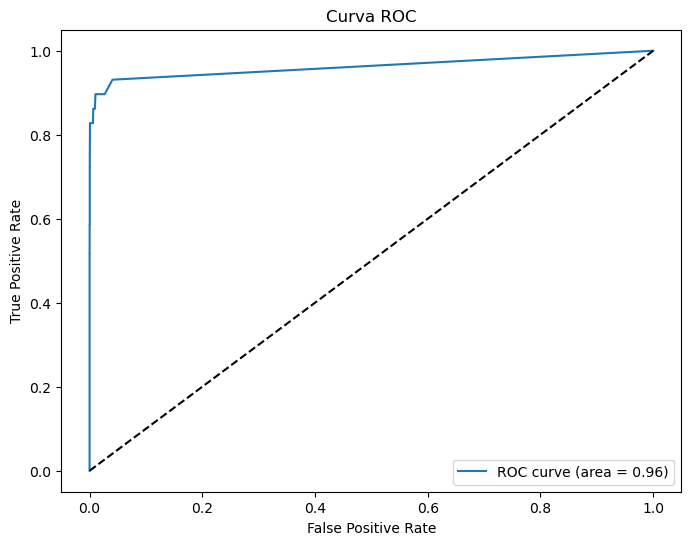

In [26]:
# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = random_forest.predict(x_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
matrix_graph = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_graph.plot()
plt.title('Confusion Matrix')
plt.show()

# Calcular el recall y la precisión
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precisión:", precision)
print("Recall:", recall)

# Calcular la probabilidad de fraude para las predicciones
y_pred_prob = random_forest.predict_proba(x_test)[:, 1]

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, y_pred_prob)
print("Área bajo la curva ROC:", auc)

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### La variable recall indica que no todos los casos de fraude están siendo procesados correctamente y hay una muy buena precisión de predicción pero se está ignorando de alguna manera dichos datos (poco menos de la mitad). Es bastante posible que esto nos indique que el modelo tiene un grado de overfitting considerable

## XGboost Classifier Tunning

In [28]:
# Calculando la proporción entre la cantidad de registros de la clase negativa y positiva
neg_count = np.sum(y_train == 0)  # Cantidad de registros de la clase negativa
pos_count = np.sum(y_train == 1)  # Cantidad de registros de la clase positiva

scale_pos_weight = neg_count / pos_count
scale_pos_weight

933.3678160919541

In [29]:
from xgboost import XGBClassifier
xgboost = XGBClassifier(
    learning_rate= 0.1,
    max_depth= 8,
    n_estimators = 600,
    scale_pos_weight = 933, #relación entre transacciones no fraudulentas y fraudulentas
    subsample = 0.8,
    colsample_bytree = 0.9,
    reg_alpha = 0.1
)
xgboost.fit(x_train, y_train)
xgboost_score = xgboost.score(x_test, y_test)
xgboost_score

0.9995571519952763

### Análisis de resultados de XGboost Classifier

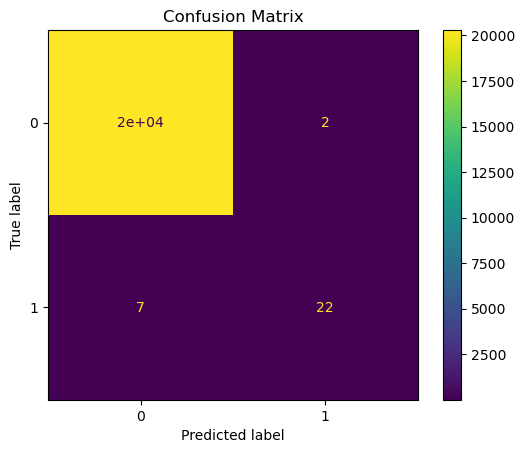

Precisión: 0.9166666666666666
Recall: 0.7586206896551724
Área bajo la curva ROC: 0.9937317977455542


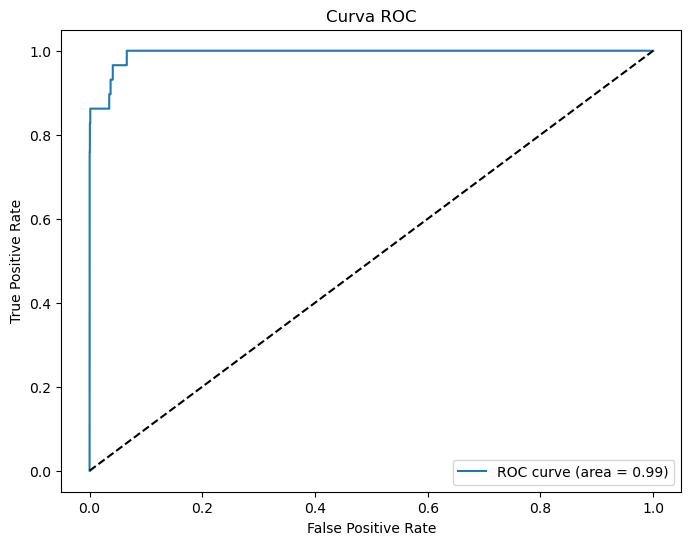

In [30]:
# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = xgboost.predict(x_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
matrix_graph = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_graph.plot()
plt.title('Confusion Matrix')
plt.show()

# Calcular el recall y la precisión
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precisión:", precision)
print("Recall:", recall)

# Calcular la probabilidad de fraude para las predicciones
y_pred_prob = xgboost.predict_proba(x_test)[:, 1]

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, y_pred_prob)
print("Área bajo la curva ROC:", auc)

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### En este caso, el modelo muestra un buen rendimiento en la clasificación de las transacciones según la precisión y la matriz de confusión, evidenciando que logró clasificar gran parte de las transacciones de forma correcta, además teniendo una tasa decente de recall, un 75.8%, lo que quiere decir que está detectando bien la mayoría de los fraudes.

### Esta fue la versión del modelo que mejores resultados obtuvo

In [32]:
xgboost.save_model("XGboostFraudes.xgb")